In [1]:
# user defined functions
import odor_statistics_lib as osm

# dataframes
import pandas as pd
import h5py

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import signal
from scipy import stats

#plots
import figurefirst
from figurefirst import FigureLayout,mpl_functions
import matplotlib.ticker as mtick
import pylab as plt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns
sns.set()
sns.set_style("whitegrid")

# plt.rcParams['text.usetex'] = True
# plt.rcParams["ps.usedistiller"] = 'xpdf'
# plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

In [2]:
dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/HighRes/'
# dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/Forest/'

In [3]:
def get_statistics(df,index,fdf):
    osm.avg_distance(df,index,fdf)
    osm.mean_conc(df,index,fdf)
    osm.motion_statistics(df,index,fdf)
    osm.whiff_blank_duration(df,index,fdf)
    osm.trajectory_speed(df,index,fdf)
    osm.encounter_frequency(df,index,fdf)
    osm.mean_avg(df,index,fdf)

In [19]:
df = pd.read_hdf(dir+'NotWindy/NotWindyMASigned1.h5')
# df['nearest_from_streakline_']=df.nearest_from_streakline
index = osm.get_index(df)
fdf = pd.DataFrame()
get_statistics(df,index,fdf)

/Users/an/Documents/MyFiles/DataAnalysis/FlyDataAnalysis/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/an/Documents/MyFiles/DataAnalysis/FlyDataAnalysis/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [20]:
df["nfs"]=df.nearest_from_streakline
df.nfs=df.nfs*df.ysign   

In [13]:
## calculation for moving average alignment
# newma=np.pad(df.ma_fraction,(200,0),mode='constant', constant_values=(0))
# newma=newma[:-200]

In [18]:
# df.to_hdf(dir+'NotWindy/NotWindyMASigned1.h5', key='df', mode='w')

### Odor Encounter Map Plots

In [21]:
df["distance_from_source_a"]=np.sqrt(df.distance_from_source**2 - df.nearest_from_streakline**2)

In [22]:
q='odor>=4.5'
dfdist=df.query(q)

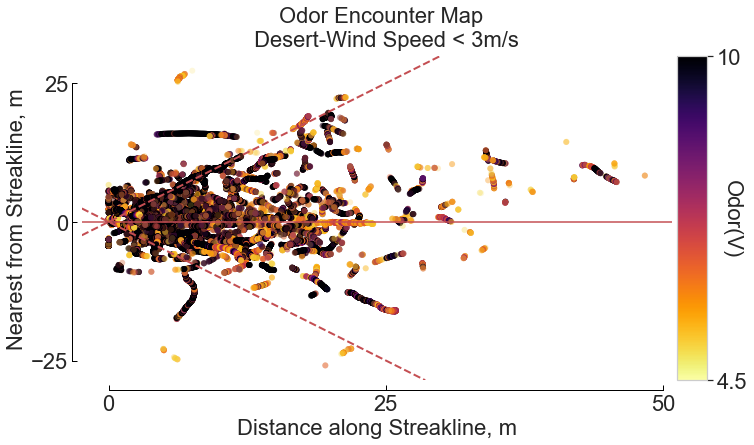

In [24]:
f,ax=plt.subplots(1,1,figsize=(10,6))
var = ax.scatter(dfdist.distance_from_source_a,dfdist.nfs,c=dfdist.odor, cmap="inferno_r",
           edgecolors='none', alpha=0.2, vmin=4, vmax=10)
ax.grid(False)
ax.axline((0,0),slope=1, linestyle='dashed', linewidth=2, color='r')
ax.axhline(0, color = 'r')
ax.axline((0, 0), slope=-1, linestyle='dashed', linewidth=2, color='r')
mpl_functions.adjust_spines(ax,['left', 'bottom'],spine_locations={},
                            smart_bounds=True, xticks=[0,25,50],yticks=[-25,0,25],linewidth=1)

ax.set_xlabel('Distance along Streakline, m')
ax.set_ylabel('Nearest from Streakline, m')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(var, cax=cax, orientation = 'vertical', ticks=[4, 10])
cbar.ax.set_yticklabels(['4.5', '10'])
cbar.ax.set_ylabel('Odor(V)', rotation=-90, labelpad=-5)
cbar.solids.set(alpha=1)
f.suptitle("Odor Encounter Map \n Desert-Wind Speed < 3m/s")
f.tight_layout(pad=1)
figurefirst.mpl_functions.set_fontsize(f, 22)
f.savefig('../../Figure/Plots/DistanceMappingLWS.jpeg', dpi=300, bbox_inches = "tight")

### Odor Statistics Calculation Plots

In [8]:
# f,(ax)=plt.subplots(4,1,figsize=(8.5,11))
# ##plots
# ax[0].plot(df.time,df.odor)
# # ax[0].axhline(4.5, linestyle='dashed', color='r')
# ax[0].set_xlim(1535,1540)
# ax[1].plot(df.time,df.whiff_plot)
# ax[1].set_xlim(1535,1540)
# # ax[2].plot(df.time,df.efreq)
# # ax[2].set_xlim(1535,1540)
# ax[2].plot(df.time, df.encounter_frequency)
# ax[2].set_xlim(1535,1540)
# ax[3].plot(df.time,df.ma_fraction)
# ax[3].set_xlim(1535,1540)

# ## adjust spines and grids
# for i in range(5):
#     ax[i].grid(False)
# mpl_functions.adjust_spines(ax[0],['left'],spine_locations={},smart_bounds=True, yticks=[0,10],linewidth=1)
# for i in range(1,3):
#     mpl_functions.adjust_spines(ax[i],['left'],spine_locations={},smart_bounds=True, yticks=[0,10.0],linewidth=1)
# mpl_functions.adjust_spines(ax[2],['left'],spine_locations={},
#                             smart_bounds=True, yticks=[0,10],linewidth=1)
# mpl_functions.adjust_spines(ax[3],['left', 'bottom'],spine_locations={},
#                             smart_bounds=True,yticks=[0,1],linewidth=1)

# ## label
# ax[0].set_ylabel('Odor, V')
# ax[1].set_ylabel('Whiff Duration, V')
# # ax[2].set_ylabel('Encounter\nOnsets')
# ax[2].set_ylabel('Encounter\nFrequency,Hz')
# ax[3].set_ylabel('Moving\nAverage, V')
# ax[3].set_xlabel('Time, s')


# f.suptitle("Odor Statistics Calculation\nOdor Threshold > 4.5V")
# f.tight_layout(pad=2)
# figurefirst.mpl_functions.set_fontsize(f, 22)
# # f.savefig('../../Figure/Plots/IntBlank.jpeg', dpi=300, bbox_inches = "tight")

### Odor Statistics Plots

In [71]:
avg_dist_along_streakline = []
i = 0
while i<len(index):
    avg_dist_along_streakline.append(np.mean(df.distance_from_source_a[index[i]]))
    i+=1
fdf['avg_dist_along_streakline']=avg_dist_along_streakline

In [ ]:
fdf["log_dist_along_streakline"]=np.log10(fdf.avg_dist_along_streakline)

In [33]:
slope, intercept, r_value, p_value, std_err = stats.linregress(fdf['log_avg_dist_from_source'],fdf['log_whiff'])

if p_value<=0.05:
    print ('significant')
    print("p_value:", p_value)
    print('r2_value:', r_value**2)
else:
    print ('insignificant')
    print("p_value:%.20f" %p_value)

significant
p_value: 0.004921144399603707
r2_value: 0.002244441851794042


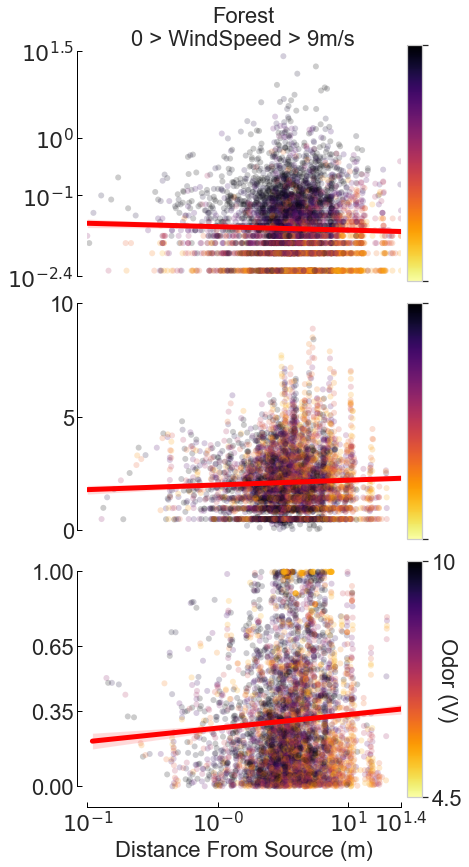

In [9]:
f,(ax1,ax2,ax3)=plt.subplots(3,1, figsize=(6,12))


var1 = ax1.scatter(fdf.log_avg_dist_from_source, fdf.log_whiff, c=fdf.mean_concentration, cmap='inferno_r', 
            edgecolors='none', alpha=0.2, vmin=4, vmax=10)
ax1.grid(False)
g1 =sns.regplot(x="log_avg_dist_from_source",y="log_whiff", data=fdf, 
            ax=ax1, line_kws={'color':'red','linewidth':5}, scatter=False, truncate=True)
g1.set(xlabel=None, ylabel=None)

# ax1.set_ylabel('Whiff Duration (s)')
mpl_functions.adjust_spines(ax1,['left'],
                            spine_locations={}, 
                            smart_bounds=True,
                           
                            yticks=[-2.4,-1,0,1.5],
                            linewidth=1)
ax1.yaxis.set_label_coords(-0.2, 0.5)
ax1.set_yticklabels([r'$10^{-2.4}$',r'$10^{-1}$', r'$10^0$', r'$10^{1.5}$'])

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var1, cax=cax1, orientation = 'vertical', ticks=[4, 10])
cbar1.solids.set(alpha=1)
cbar1.ax.set_yticklabels([])

########## subplot 1 #############

var2 = ax2.scatter(fdf.log_avg_dist_from_source, fdf.mean_ef, c=fdf.mean_concentration, cmap='inferno_r', 
            edgecolors='none', alpha=0.2, vmin=4, vmax=10)
ax2.grid(False)
g2 = sns.regplot(x="log_avg_dist_from_source",y="mean_ef", data=fdf, 
            ax=ax2, line_kws={'color':'red','linewidth':5}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)
# ax2.set_xlabel('Distance From Source (m)')
# ax2.set_ylabel('Whiff Frequency (Hz)')

mpl_functions.adjust_spines(ax2,['left'],
                            spine_locations={}, 
                            smart_bounds=True,     
                            yticks=[0,5,10],
                            linewidth=1)
ax2.yaxis.set_label_coords(-0.2, 0.5)

divider = make_axes_locatable(ax2)
cax2 = divider.append_axes('right', size='5%', pad=0.08)
cbar2=f.colorbar(var2, cax=cax2, orientation = 'vertical', ticks=[4, 10])
cbar2.solids.set(alpha=1)
cbar2.ax.set_yticklabels([])


########## subplot 2 #############

var3 = ax3.scatter(fdf.log_avg_dist_from_source, fdf.mean_ma, c=fdf.mean_concentration, cmap='inferno_r', 
                   edgecolors='none', alpha=0.2, vmin=4, vmax=10)
ax3.grid(False)
g3=sns.regplot(x="log_avg_dist_from_source",y="mean_ma", data=fdf, 
            ax=ax3, line_kws={'color':'red','linewidth':5}, scatter=False, truncate=False)
g3.set(xlabel=None, ylabel=None)
ax3.set_xlabel('Distance From Source (m)')
# ax3.set_ylabel('Whiff Moving\nAverage (V)')
mpl_functions.adjust_spines(ax3,['left','bottom'],
                            spine_locations={}, 
                            smart_bounds=True,
                            xticks=[-1,0,1,1.4],
                            yticks=[0,0.35,0.65,1],
                            linewidth=1)
ax3.yaxis.set_label_coords(-0.2, 0.5)
ax3.set_xticklabels([r'$10^{-1}$',r'$10^{-0}$', r'$10^1$', r'$10^{1.4}$'])

divider = make_axes_locatable(ax3)
cax3 = divider.append_axes('right', size='5%', pad=0.08)
cbar3=f.colorbar(var3, cax=cax3, orientation = 'vertical', ticks=[4, 10])
cbar3.ax.set_yticklabels(['4.5', '10'])
cbar3.solids.set(alpha=1)
cbar3.ax.set_ylabel('Odor (V)', rotation=-90, labelpad=-5)


########## subplot 3 #############
# f.suptitle('Desert\n Wind Speed > 3m/s')
f.suptitle("Forest\n0 > WindSpeed > 9m/s")
f.tight_layout(pad=1)
figurefirst.mpl_functions.set_fontsize(f, 22)

f.savefig('../../Figure/Plots/FStat.jpeg', dpi=300, bbox_inches = "tight")

In [63]:
# fdf = pd.read_hdf(dir+'ForestStats.h5')

In [65]:
# fdf = osm.sort_by_distance(fdf)

In [11]:
# logwhiff=smf.ols(formula=' avg_dist_from_source ~ log_whiff', data=fdf).fit()
# ef=smf.ols(formula=' avg_dist_from_source ~ mean_ef', data=fdf).fit()
# ma=smf.ols(formula=' avg_dist_from_source ~ mean_ma', data=fdf).fit()

In [53]:
whiff_frequency=smf.ols(formula='mean_ef ~ np.abs(fdf.avg_perpendicular_encounter) + np.abs(fdf.avg_parallel_encounter)', data=fdf).fit()
whiff_duration=smf.ols(formula='log_whiff~ np.abs(fdf.avg_perpendicular_encounter) + np.abs(fdf.avg_parallel_encounter)', data=fdf).fit()
moving_avg = smf.ols(formula='mean_ma ~ np.abs(fdf.avg_perpendicular_encounter) + np.abs(fdf.avg_parallel_encounter)', data=fdf).fit()

In [54]:
fdf['whiff_frequency_resid']=whiff_frequency.resid
fdf['whiff_duration_resid'] = whiff_duration.resid
fdf['moving_avg_resid'] = moving_avg.resid

In [55]:
distance=smf.ols(formula='log_avg_dist_from_source ~ whiff_duration_resid  + whiff_frequency_resid + moving_avg_resid', data=fdf).fit()
print(distance.summary())

                               OLS Regression Results                               
Dep. Variable:     log_avg_dist_from_source   R-squared:                       0.074
Model:                                  OLS   Adj. R-squared:                  0.072
Method:                       Least Squares   F-statistic:                     39.19
Date:                      Thu, 03 Mar 2022   Prob (F-statistic):           2.28e-24
Time:                              09:47:23   Log-Likelihood:                -303.37
No. Observations:                      1478   AIC:                             614.7
Df Residuals:                          1474   BIC:                             635.9
Df Model:                                 3                                         
Covariance Type:                  nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

In [56]:
distance.pvalues.moving_avg_resid

1.017529676473528e-13

In [57]:
print("p_value:%.20f" %distance.pvalues.whiff_duration_resid)
print("p_value:%.20f" %distance.pvalues.whiff_frequency_resid)
print("p_value:%.20f" %distance.pvalues.moving_avg_resid)

p_value:0.07565366082193640540
p_value:0.00001460372401913663
p_value:0.00000000000010175297


In [89]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
name = ["Jarque-Bera", "Chi^2 two-tail prob.", "Skew", "Kurtosis"]
test = sms.jarque_bera(distance.resid)
lzip(name, test)

[('Jarque-Bera', 80.82580865890148),
 ('Chi^2 two-tail prob.', 2.8112447152786083e-18),
 ('Skew', -0.36805972421530264),
 ('Kurtosis', 3.094341284576008)]

In [ ]:
## f,ax=plt.subplots(1,1,figsize=(15,8)) 
# mod = sm.graphics.plot_fit(distance, "mean_ef", ax=ax)
# ax.set_xlabel('Whiff Frequency')
# ax.set_ylabel('Distance From Source')
# ax.grid(False)
# mpl_functions.adjust_spines(ax,['left','bottom'],
#                             spine_locations={}, 
#                             smart_bounds=True,
#                             xticks=[0,4,8],
#                             yticks=[-20,20,55],
#                             linewidth=1)


# f.suptitle("Fitted Values Versus Whiff Frequency")
# f.tight_layout(pad=1)
# figurefirst.mpl_functions.set_fontsize(f, 22)


In [ ]:
# ## BootStrapping Results for Distance ~ Odor Statistics

# sns.set_style('whitegrid')
# f, ((ax1,ax2,ax3,ax4)) = plt.subplots(4,1, figsize=(16,14))
# ax1.plot(rdf.angles,rdf.rsquared)
# ax1.set_yticks([rdf.rsquared.min(), rdf.rsquared.max()])
# ax1.set_ylabel('$R^2$', rotation = 0, color='blue')
# set_grid_false(ax1)
# ax1.yaxis.set_label_coords(-0.04,0.45)
# ax1.axes.get_xaxis().set_visible(False)

# ax2.plot(rdf.angles,rdf.p_whiff_length)
# ax2.set_yticks([rdf.p_whiff_length.min(), rdf.p_whiff_length.max()])
# ax2.set_ylabel('$p-value$\nWhiff Duration', rotation = 0, color='blue')
# set_grid_false(ax2)
# ax2.yaxis.set_label_coords(-0.08,0.4)
# ax2.axes.get_xaxis().set_visible(False)

# ax3.plot(rdf.angles, rdf.p_encounter_frequency)
# ax3.set_yticks([rdf.p_encounter_frequency.min(),rdf.p_encounter_frequency.max()])
# ax3.set_ylabel('$p-value$\nEncounter Frequency', rotation = 0, color='blue')
# set_grid_false(ax3)
# ax3.yaxis.set_label_coords(-0.1,0.4)
# ax3.axes.get_xaxis().set_visible(False)

# ax4.plot(rdf.angles, rdf.p_moving_avg)
# ax4.set_yticks([rdf.p_moving_avg.min(),rdf.p_moving_avg.max()])
# ax4.set_xticks([45, 50, 55, 60, 65, 70, 75, 80, 85, 90])
# ax4.set_ylabel('$p-value$\nMoving Average', rotation = 0, color='blue')
# set_grid_false(ax4)
# ax4.yaxis.set_label_coords(-0.08,0.4)
# ax4.set_xlabel('Change in Direction', color='blue')

# f.suptitle('Wind Speed < 3m/s\nDistance ~ Odor-Statistics', fontsize='medium')
# f.tight_layout(pad=4)
# figurefirst.mpl_functions.set_fontsize(f, 18)
# # f.savefig('../../Figure/changeInDirNotWindy.jpeg', dpi=1000) 
# # f.savefig('../../Figure/removeddisc.svg', format='svg',dpi=1200)